# Preprocessing Danish dataset for reinflection

For the Danish Inflection system, the alpha model, the dataset splits were 70% 15% 15% (7842; 1681; 1680). We have to obtain a new Danish dataset by combining danish-train-medium with danish-covered-test, which will be tagged using the psi model.

## Imports & Installs

In [17]:
import os

from datasets import Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
import torch
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, EvalPrediction, pipeline
import wandb

## Obtainint the new predictions

In [2]:
def create_dataset(path_file1) -> pd.DataFrame:

    df = pd.read_csv(path_file1, sep="\t", header=None)

    # reset the index
    df.reset_index(drop=True, inplace=True)

    # rename columns
    df.rename(columns={0: 'lemma', 1: 'inflected form', 2: 'PoS'}, inplace=True)

    # shuffle columns
    df = df.sample(frac=1, axis=0, random_state=123)

    return df

danish_df = create_dataset("../data/sigmorphon2017/danish-covered-test/danish-covered-test.txt")
danish_df.head()

,lemma,inflected form,PoS
131,hals,hals,N;INDF;NOM;SG
203,chok,chokkenes,N;DEF;NOM;PL
50,børs,børser,N;INDF;NOM;PL
585,variere,varier,V;ACT;IMP
138,rødlos,rødlosser,N;INDF;NOM;PL


In [3]:
morphological_tags = {}

for index, row in danish_df.iterrows():
  pos_tags = row["PoS"]

  # Split the string with tags and create a list
  list_tags = pos_tags.split(";")

  # Append the tags into the set
  for tag in list_tags:
    if tag not in morphological_tags.keys():
      morphological_tags[tag] = 1
    else:
      morphological_tags[tag] += 1

# Order the dictionary in a list in alphabetical order
morphological_tags_list = sorted(morphological_tags.keys(), key=lambda x: x[0])

print(morphological_tags)
print(morphological_tags_list)

{'N': 935, 'INDF': 607, 'NOM': 646, 'SG': 474, 'DEF': 328, 'PL': 461, 'V': 51, 'ACT': 37, 'IMP': 9, 'GEN': 289, 'PASS': 28, 'IND': 37, 'PRS': 23, 'NFIN': 5, 'V.PTCP': 14, 'PST': 28}
['ACT', 'DEF', 'GEN', 'INDF', 'IMP', 'IND', 'N', 'NOM', 'NFIN', 'PL', 'PASS', 'PRS', 'PST', 'SG', 'V', 'V.PTCP']


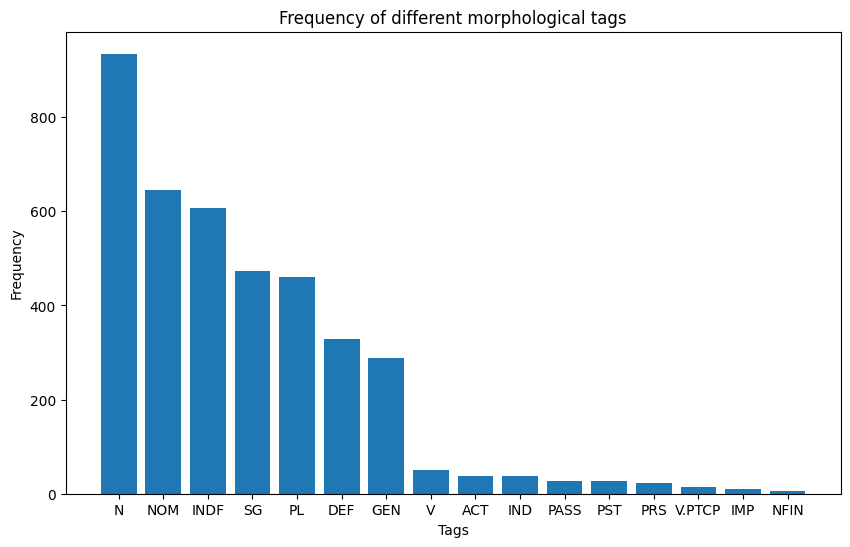

In [4]:
# Sort the dictionary by value
sorted_dict = {k: v for k, v in sorted(morphological_tags.items(), key=lambda x: x[1], reverse=True)}

# Plot the sorted dictionary as a bar chart
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(list(sorted_dict), [v for k, v in sorted_dict.items()])
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Frequency of different morphological tags')
plt.show()

In [5]:
# Removing PoS column
danish_df = danish_df.drop("PoS", axis=1)
danish_df.head()

,lemma,inflected form
131,hals,hals
203,chok,chokkenes
50,børs,børser
585,variere,varier
138,rødlos,rødlosser


In [6]:
# Unifying lemma and inflected form
danish_df.insert(0, 'text', 'default')

# Now, we need to populate the columns
for index, row in danish_df.iterrows():

  danish_df.at[index, "text"] = row["lemma"] + "[SEP]" + row["inflected form"]

# And finally, we can remove the original columns
danish_df = danish_df.drop("lemma", axis=1)
danish_df = danish_df.drop("inflected form", axis=1)
danish_df.head()

,text
131,hals[SEP]hals
203,chok[SEP]chokkenes
50,børs[SEP]børser
585,variere[SEP]varier
138,rødlos[SEP]rødlosser


In [8]:
ds = Dataset.from_pandas(danish_df)
ds

Dataset({
    features: ['text', '__index_level_0__'],
    num_rows: 1000
})

In [13]:
tokenizer = AutoTokenizer.from_pretrained("../danish_morpho_psi/best_psi_model/")

In [14]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

ds = ds.map(preprocess_function, batched=True)
ds[0]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'text': 'hals[SEP]hals',
 '__index_level_0__': 131,
 'input_ids': [101, 11085, 2015, 102, 11085, 2015, 102],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [15]:
model = AutoModelForSequenceClassification.from_pretrained("../danish_morpho_psi/best_psi_model/")

In [32]:
# Create a text classification pipeline
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, return_all_scores=True)

# Make predictions
untokenized_input = []
for record in ds:
    untokenized_input.append(record["text"])

predictions = classifier(untokenized_input)
predictions

/Users/ignacio/.local/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'ACT', 'score': 0.015430332161486149},
  {'label': 'DEF', 'score': 0.06785043329000473},
  {'label': 'GEN', 'score': 0.18903498351573944},
  {'label': 'INDF', 'score': 0.9350069165229797},
  {'label': 'IMP', 'score': 0.012087339535355568},
  {'label': 'IND', 'score': 0.013879107311367989},
  {'label': 'N', 'score': 0.9805750846862793},
  {'label': 'NOM', 'score': 0.8280555605888367},
  {'label': 'NFIN', 'score': 0.015117502771317959},
  {'label': 'PL', 'score': 0.10299466550350189},
  {'label': 'PASS', 'score': 0.012726062908768654},
  {'label': 'PRS', 'score': 0.01061909832060337},
  {'label': 'PST', 'score': 0.01423549558967352},
  {'label': 'SG', 'score': 0.8833058476448059},
  {'label': 'V', 'score': 0.013427350670099258},
  {'label': 'V.PTCP', 'score': 0.013199243694543839}],
 [{'label': 'ACT', 'score': 0.027046754956245422},
  {'label': 'DEF', 'score': 0.9198685884475708},
  {'label': 'GEN', 'score': 0.03830120712518692},
  {'label': 'INDF', 'score': 0.061960417777299

In [40]:
# Set the probability threshold
threshold = 0.5

# Filter predictions based on the threshold
filtered_predictions = []

for pred in predictions:
    sublist = ""

    for label in pred:
        if label["score"]>threshold:
            sublist += label["label"]+";"


    filtered_predictions.append(sublist[:-1])

# Now, 'filtered_predictions' contains all labels with scores higher than the threshold
print(filtered_predictions)

# Now, 'predictions' contains the predicted labels and scores for each input
assert len(untokenized_input) == len(filtered_predictions)

['INDF;N;NOM;SG', 'DEF;N;NOM;PL', 'GEN;INDF;N;PL', 'INDF;N;NOM;PL', 'INDF;N;NOM;PL', 'INDF;N;NOM;SG', 'DEF;N;NOM;SG', 'GEN;INDF;N;SG', 'INDF;N;NOM;PL', 'DEF;N;NOM;SG', 'GEN;INDF;N;PL', 'GEN;INDF;N;PL', 'INDF;N;NOM;SG', 'GEN;INDF;N;PL', 'GEN;INDF;N;PL', 'DEF;N;NOM;PL', 'GEN;INDF;N;PL', 'GEN;INDF;N;SG', 'INDF;N;NOM;SG', 'GEN;INDF;N;SG', 'GEN;INDF;N;PL', 'GEN;INDF;N;SG', 'DEF;N;NOM;SG', 'DEF;N;NOM;PL', 'GEN;INDF;N;SG', 'GEN;INDF;N;SG', 'DEF;N;NOM;SG', 'IND;PASS;PST;V', 'GEN;INDF;N;SG', 'GEN;INDF;N;PL', 'GEN;INDF;N;PL', 'INDF;N;NOM;SG', 'INDF;N;NOM;SG', 'INDF;N;NOM;SG', 'INDF;N;NOM;SG', 'INDF;N;NOM;PL', 'INDF;N;NOM;SG', 'INDF;N;NOM;SG', 'INDF;N;NOM;PL', 'INDF;N;NOM;SG', 'INDF;N;NOM;SG', 'INDF;N;NOM;PL', 'DEF;N;NOM;SG', 'DEF;N;NOM;SG', 'DEF;N;NOM;SG', 'GEN;INDF;N;SG', 'GEN;INDF;N;SG', 'INDF;N;NOM;PL', 'ACT;IND;PST;V', 'INDF;N;NOM;SG', 'DEF;N;NOM;PL', 'INDF;N;NOM;PL', 'INDF;N;NOM;PL', 'DEF;N;NOM;PL', 'INDF;N;NOM;PL', 'DEF;N;NOM;SG', 'INDF;N;NOM;SG', 'GEN;INDF;N;SG', 'GEN;INDF;N;PL', 'DEF;N;N

In [41]:
danish_covered_predicted = pd.DataFrame(columns=["lemma", "inflected", "prediction"])

for inp, pred in zip(untokenized_input, filtered_predictions):
    lemma, inflected = inp.split("[SEP]")
    danish_covered_predicted = danish_covered_predicted.append({"lemma": lemma, "inflected": inflected, "prediction": pred}, ignore_index=True)

danish_covered_predicted.head()

/var/folders/s0/4h4_2s7n3wxbm06wx8y43mm80000gn/T/ipykernel_75339/2353283926.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  danish_covered_predicted = danish_covered_predicted.append({"lemma": lemma, "inflected": inflected, "prediction": pred}, ignore_index=True)
/var/folders/s0/4h4_2s7n3wxbm06wx8y43mm80000gn/T/ipykernel_75339/2353283926.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  danish_covered_predicted = danish_covered_predicted.append({"lemma": lemma, "inflected": inflected, "prediction": pred}, ignore_index=True)
/var/folders/s0/4h4_2s7n3wxbm06wx8y43mm80000gn/T/ipykernel_75339/2353283926.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  danish_covered_predicted = danish_covered_predicted.append({"lemma": 

,lemma,inflected,prediction
0,hals,hals,INDF;N;NOM;SG
1,chok,chokkenes,DEF;N;NOM;PL
2,børs,børser,GEN;INDF;N;PL
3,variere,varier,INDF;N;NOM;PL
4,rødlos,rødlosser,INDF;N;NOM;PL


In [42]:
danish_covered_predicted.to_csv('danish-covered-text-predicted.txt', sep='\t', index=False)

## Combine the predictions with danish-train-medium and create the dataset for Gamma model

In [79]:
def combine_dataset(path1:str, path2:str) -> pd.DataFrame:

    df_1 = pd.read_csv(path1, sep="\t", header=None)
    df_2 = pd.read_csv(path2, sep="\t", header=None)
    df = pd.concat([df_1, df_2])

    # reset the index
    df.reset_index(drop=True, inplace=True)

    # rename columns
    df.rename(columns={0: 'lemma', 1: 'inflected form', 2: 'PoS'}, inplace=True)

    # shuffle columns
    df = df.sample(frac=1, axis=0, random_state=123)

    return df

danish_df = combine_dataset("../data/sigmorphon2017/danish-covered-test/danish-train-medium.txt", "../data/sigmorphon2017/danish-covered-test/danish-covered-text-predicted.txt")

print(len(danish_df))
danish_df

2000


,lemma,inflected form,PoS
1342,vejskilt,vejskilts,GEN;INDF;N;SG
1338,potentat,potentaters,GEN;INDF;N;PL
189,rig,rigges,N;INDF;GEN;PL
1332,præsident,præsident,INDF;N;NOM;SG
1816,langfredag,langfredagenes,DEF;N;NOM;PL
...,...,...,...
1122,sammenskrivning,sammenskrivningens,DEF;N;NOM;SG
1346,brugerdiskussion,brugerdiskussionens,DEF;N;NOM;SG
1406,quinde,quinders,GEN;INDF;N;PL
1389,kirkegård,kirkegårde,INDF;N;NOM;PL


In [80]:
danish_df

,lemma,inflected form,PoS
1342,vejskilt,vejskilts,GEN;INDF;N;SG
1338,potentat,potentaters,GEN;INDF;N;PL
189,rig,rigges,N;INDF;GEN;PL
1332,præsident,præsident,INDF;N;NOM;SG
1816,langfredag,langfredagenes,DEF;N;NOM;PL
...,...,...,...
1122,sammenskrivning,sammenskrivningens,DEF;N;NOM;SG
1346,brugerdiskussion,brugerdiskussionens,DEF;N;NOM;SG
1406,quinde,quinders,GEN;INDF;N;PL
1389,kirkegård,kirkegårde,INDF;N;NOM;PL


In [81]:
for index, row in danish_df.iterrows():
    if type(row["PoS"]) != str:
        print(type(row["PoS"]))
        danish_df = danish_df.drop(index)

print(danish_df)

<class 'float'>
                 lemma       inflected form            PoS
1342          vejskilt            vejskilts  GEN;INDF;N;SG
1338          potentat          potentaters  GEN;INDF;N;PL
189                rig               rigges  N;INDF;GEN;PL
1332         præsident            præsident  INDF;N;NOM;SG
1816        langfredag       langfredagenes   DEF;N;NOM;PL
...                ...                  ...            ...
1122   sammenskrivning   sammenskrivningens   DEF;N;NOM;SG
1346  brugerdiskussion  brugerdiskussionens   DEF;N;NOM;SG
1406            quinde             quinders  GEN;INDF;N;PL
1389         kirkegård           kirkegårde  INDF;N;NOM;PL
1534              kusk               kuskes  GEN;INDF;N;PL

[1999 rows x 3 columns]


In [82]:
def spacify(x):
    return  '< ' +''.join([c + ' ' for c in x]) + '>'

def semicolons_for_spaces(x):
    return x.replace(";", " ")

In [83]:
def output_splits(danish_df) -> None:

    language = "dan"

    # Split strings in spaces and add <>, so adelantar turns into < a d e l a n t a r >
    # change all rows of column A by adding 2
    print(danish_df['lemma'])
    danish_df['lemma'] = danish_df['lemma'].apply(spacify)
    print(danish_df['lemma'])
    danish_df['inflected form'] = danish_df['inflected form'].apply(spacify)

    # In PoS tags, change ; for spaces
    danish_df['PoS'] = danish_df['PoS'].apply(semicolons_for_spaces)

    train_df, temp_df = train_test_split(danish_df, test_size=0.3, random_state=42)

    # Now, temp_df contains 30% of the original data
    # Next, split temp_df into dev and test sets (50% of the remaining data each)
    dev_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

    # Check the sizes of the resulting sets
    print("Train set size:", len(train_df))
    print("Dev set size:", len(dev_df))
    print("Test set size:", len(test_df))

    # Now, we need to export the data in both the input and the output format
    for split in ["train", "dev", "tst"]:

        input_file = open(f"{split}.{language}.input", "w")
        output_file = open(f"{split}.{language}.output", "w")

        dataframe = 0

        if split == "train":
            dataframe = train_df
        elif split == "dev":
            dataframe = dev_df
        else:
            dataframe = test_df

        # Export input file
        for _,line in dataframe.iterrows():
            input_file.write(f"{line['lemma']} {line['PoS']}\n")
            output_file.write(f"{line['inflected form']}\n")

        input_file.close()
        output_file.close()

output_splits(danish_df)

1342            vejskilt
1338            potentat
189                  rig
1332           præsident
1816          langfredag
              ...       
1122     sammenskrivning
1346    brugerdiskussion
1406              quinde
1389           kirkegård
1534                kusk
Name: lemma, Length: 1999, dtype: object
1342                    < v e j s k i l t >
1338                    < p o t e n t a t >
189                               < r i g >
1332                  < p r æ s i d e n t >
1816                < l a n g f r e d a g >
                       ...                 
1122      < s a m m e n s k r i v n i n g >
1346    < b r u g e r d i s k u s s i o n >
1406                        < q u i n d e >
1389                  < k i r k e g å r d >
1534                            < k u s k >
Name: lemma, Length: 1999, dtype: object
Train set size: 1399
Dev set size: 300
Test set size: 300
